## Difference-in-Differences (DiD) Analysis

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.regressionplots import influence_plot
from IPython.display import display
from tqdm import trange

### Nationwide DiD with Group & Year Fixed Effects

To control for average differences across groups and over time, we estimate:

$log(CR_{gt})
=
\beta\,(T_{g}\times P_{t})
\;+\;FE_{g}
\;+\;FE_{t}
\;+\;\varepsilon_{gt}.$
- This absorbs any group-specific level and common time shocks.
- We still interpret the $T\times P$ coefficient as the causal effect.

This regression is conducted on the **nationwide dataset**

In [9]:
# Nationwide aggregated DiD
df_agg = pd.read_excel('/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/processed/crimes_subject_to_law_cleaned.xlsx')
df_agg['T'] = (df_agg['group']=="Foreigner").astype(int)
df_agg['P'] = (df_agg['year']>=2017).astype(int)
df_agg['log_crime_rate'] = np.log(df_agg['crime_rate_per_100k'])

model = smf.ols("log_crime_rate ~ T:P + C(group) + C(year)", data=df_agg).fit()
print("Nationwide DiD (w/ Fixed Effects)")
print(model.summary())

Nationwide DiD (w/ Fixed Effects)
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     315.7
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           3.27e-13
Time:                        00:12:29   Log-Likelihood:                 58.401
No. Observations:                  28   AIC:                            -84.80
Df Residuals:                      12   BIC:                            -63.49
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Inte

### Canton-Panel DiD

$log(CR_{cgt})
= \beta\,(T_{g}\times P_{t})
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt}.$

In [10]:
# Canton-panel DiD
df_ct = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/processed/crimes_subject_to_law_cleaned_by_canton.xlsx")


good = []
for c in df_ct['canton'].unique():
    sub = df_ct[df_ct['canton']==c]
    good.append(c)
df_ct = df_ct[df_ct['canton'].isin(good)].copy()


df_ct['log_crime_rate'] = np.log(df_ct['crime_rate_per_100k'])
df_ct = df_ct[df_ct['log_crime_rate']>=0]
df_ct['T'] = (df_ct['group']=="Foreigner").astype(int)
df_ct['P'] = (df_ct['year']>=2017).astype(int)
df_ct['T_P'] = df_ct['T'] * df_ct['P']
df_ct['t'] = df_ct['year'] - df_ct['year'].min()
df_ct['T_t'] = df_ct['T'] * df_ct['t']

mod1 = smf.ols("log_crime_rate ~ T_P + C(canton) + C(year) + C(group)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (simple)")
print(mod1.summary())


Canton-panel DiD (simple)
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     182.1
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           1.62e-19
Time:                        00:12:30   Log-Likelihood:                -278.76
No. Observations:                 556   AIC:                             633.5
Df Residuals:                     518   BIC:                             797.7
Df Model:                          37                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 15
  warnings.warn('covariance of constraints does not have full '


### Canton-Panel DiD (parallelity hypothesis relaxed)

same model with $\theta$ variable to treat for parallelity

$log(CR_{cgt})
= \beta\,(T_{g}\times P_{t})
\;+\;\theta\,(T_{g}\times t)
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt},$

In [11]:
mod2 = smf.ols("log_crime_rate ~ T_P + T_t + C(group) + C(canton) + C(year)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (with trend)")
print(mod2.summary())


Canton-panel DiD (with trend)
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     4023.
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           2.35e-34
Time:                        00:12:30   Log-Likelihood:                -278.74
No. Observations:                 556   AIC:                             635.5
Df Residuals:                     517   BIC:                             804.0
Df Model:                          38                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 16
  warnings.warn('covariance of constraints does not have full '


### Canton-Specific DiD Regression Explanation

We estimate the following model:

$
log(CR_{cgt})
= FE_{g}
\;+\;FE_{t}
\;+\;FE_{c}
\;+\;\sum_{c}\beta_{c}\,\Bigl(\mathbf{1}\{\text{canton}=c\}\times T_{g} \times P_{t}\Bigr)
\;+\;\varepsilon_{cgt},$

In [12]:
mod3 = smf.ols("log_crime_rate ~ C(group) + C(year) + C(canton) + C(canton):T_P", data=df_ct).fit()

print(mod3.summary())

                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     31.83
Date:                Fri, 06 Jun 2025   Prob (F-statistic):          1.67e-133
Time:                        00:12:30   Log-Likelihood:                -266.60
No. Observations:                 556   AIC:                             653.2
Df Residuals:                     496   BIC:                             912.5
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

## Event study (final test)

$$
log(CR_{cgt})
= FE_{c} + FE_{t} + FE_{g}
+ \sum_{\substack{k=-5 \\ k\neq -1}}^{5}
    \beta_{k}\,\bigl[\mathbf{1}(t-2017 = k)\times D_{g}\bigr]
+ \varepsilon_{igt}
$$

In [13]:
df_ct = df_ct.copy()

# 1) Ensure year is int
df_ct['year'] = df_ct['year'].astype(int)

df_ct['treat'] = (df_ct['group'] == "Foreigner").astype(int)
print("Treated obs:", df_ct['treat'].sum(), "/", len(df_ct))

lead_cols = []
for k in range(-7, 7):
    if k == -1: 
        continue
    suffix = f"m{abs(k)}" if k < 0 else f"p{k}"
    name   = f"lead_{suffix}"
    df_ct[name] = ((df_ct['year'] - 2017) == k).astype(int) * df_ct['treat']
    print(f"{name}: {df_ct[name].sum()} treated obs")
    lead_cols.append(name)

# Event-study regression
formula = "log_crime_rate ~ " + " + ".join(lead_cols) + " + C(canton)+ C(group) + C(year)"
mod_es = smf.ols(formula, data=df_ct).fit(
    cov_type="cluster", cov_kwds={"groups": df_ct["canton"]})
print(mod_es.summary())

Treated obs: 278 / 556
lead_m7: 20 treated obs
lead_m6: 19 treated obs
lead_m5: 20 treated obs
lead_m4: 17 treated obs
lead_m3: 21 treated obs
lead_m2: 20 treated obs
lead_p0: 18 treated obs
lead_p1: 19 treated obs
lead_p2: 19 treated obs
lead_p3: 21 treated obs
lead_p4: 22 treated obs
lead_p5: 21 treated obs
lead_p6: 22 treated obs
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     94.79
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           5.14e-17
Time:                        00:12:30   Log-Likelihood:                -275.73
No. Observations:                 556   AIC:                             651.5
Df Residuals:                     506   BIC:                             867.5
Df Model:                        

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 49, but rank is 22
  warnings.warn('covariance of constraints does not have full '


## Counterfactual graph of the DiD

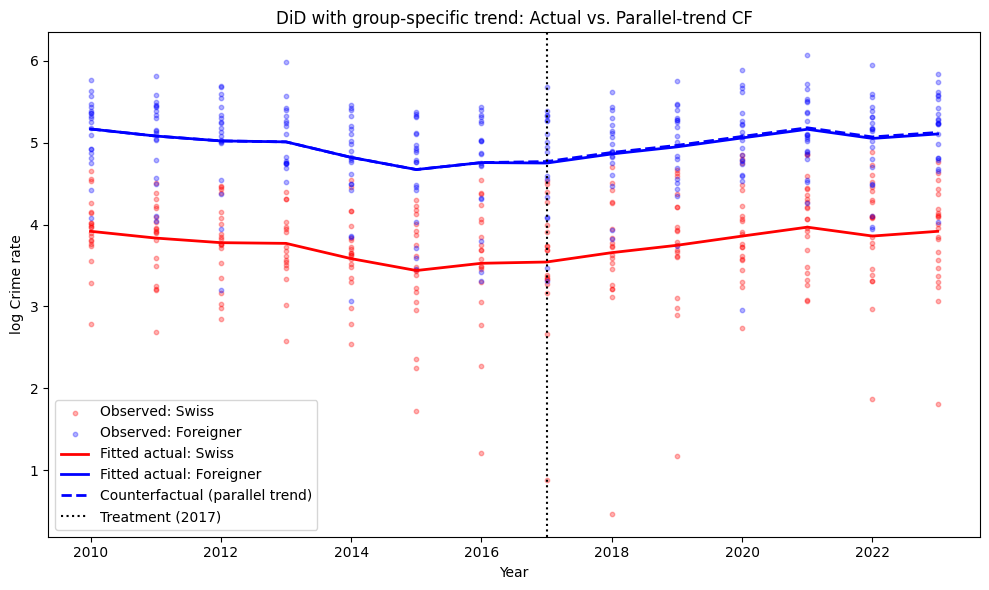

In [14]:
# Build a “counterfactual” dataset where Foreigner keeps its pre-treatment trend:
df_ct_cf = df_ct.copy()
# zero out the post dummy so the Foreigner×Post jump vanishes
df_ct_cf['T_P'] = 0

# keep the group‐specific trend term intact (so slope continues)
# T_t is just time × Foreigner, so it stays

# Predict both actual and counterfactual paths
df_ct['f_actual'] = mod2.predict(df_ct)
df_ct_cf['f_cf']    = mod2.predict(df_ct_cf)

# Aggregate to year × group means
agg = (
    df_ct
    .assign(f_cf=df_ct_cf['f_cf'])
    .groupby(['group','year'])
    .agg(obs_rate=('log_crime_rate','mean'),
         fit_actual=('f_actual','mean'),
         fit_cf    =('f_cf','mean'))
    .reset_index())

plt.figure(figsize=(10,6))

for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = df_ct[df_ct['group'] == grp]
    plt.scatter(sub['year'], sub['log_crime_rate'],
                color=color, alpha=0.3, s=10,
                label=f'Observed: {grp}')

for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = agg[agg['group']==grp]
    plt.plot(sub['year'], sub['fit_actual'], color=color, lw=2,
             label=f'Fitted actual: {grp}')
    if grp=='Foreigner':
        plt.plot(sub['year'], sub['fit_cf'], color=color, lw=2, ls='--',
                 label='Counterfactual (parallel trend)')

plt.axvline(2017, color='black', ls=':', lw=1.5, label='Treatment (2017)')

plt.xlabel('Year')
plt.ylabel('log Crime rate')
plt.title('DiD with group‐specific trend: Actual vs. Parallel‐trend CF')
plt.legend()
plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/did_graph.png", dpi=300, bbox_inches='tight')  
plt.show()

# Robustness tests

## 1. Reestimate model 1 with obs >=6

In [15]:
# Same model with obs>=6
counts = (
    df_ct
    .groupby('canton')['year']
    .agg(
        pre  = lambda yrs: (yrs < 2017).sum(),
        post = lambda yrs: (yrs >= 2017).sum()
    )
)

valid_cantons = counts[(counts['pre'] >= 3) & (counts['post'] >= 3)].index

df_filt = df_ct[df_ct['canton'].isin(valid_cantons)].copy()

mod1_filt = smf.ols(
    "log_crime_rate ~ T_P + C(group) + C(canton) + C(year)",
    data=df_filt
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_filt['canton']}
)

print("\nCanton-panel DiD (with trend) — only cantons w/ ≥3 obs pre & post")
print(mod1_filt.summary())


Canton-panel DiD (with trend) — only cantons w/ ≥3 obs pre & post
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     172.6
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           1.55e-18
Time:                        00:12:30   Log-Likelihood:                -272.06
No. Observations:                 550   AIC:                             618.1
Df Residuals:                     513   BIC:                             777.6
Df Model:                          36                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 36, but rank is 15
  warnings.warn('covariance of constraints does not have full '


## 2. leave one out : we estimate the regression each time leaving a canton out to see if an heavy outlier might bias the result

In [16]:
full_mod = smf.ols(
    "log_crime_rate ~ T_P + C(group) + C(canton) + C(year)",
    data=df_ct
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_ct['canton']}
)

results = []
cantons = df_ct['canton'].unique()

for canton in cantons:
    # Drop one canton at a time
    df_sub = df_ct[df_ct['canton'] != canton]
    mod = smf.ols(
        "log_crime_rate ~ T_P + C(group) + C(canton) + C(year)",
        data=df_sub
    ).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_sub['canton']}
    )
    results.append({
        'Removed Canton': canton,
        'Coefficient (T_P)': mod.params['T_P'],
        'Std. Err. (T_P)': mod.bse['T_P'],
        'p-value (T_P)': mod.pvalues['T_P']
    })

# Add full-sample result
results.append({
    'Removed Canton': 'None (Full Sample)',
    'Coefficient (T_P)': full_mod.params['T_P'],
    'Std. Err. (T_P)': full_mod.bse['T_P'],
    'p-value (T_P)': full_mod.pvalues['T_P']
})

df_leave_one_out = pd.DataFrame(results)

display("Leave-One-Out DiD Results", df_leave_one_out)

'Leave-One-Out DiD Results'

,Removed Canton,Coefficient (T_P),Std. Err. (T_P),p-value (T_P)
0,Aargau,-0.043799,0.078573,0.577234
1,Bern / Berne,-0.045348,0.078614,0.564041
2,Fribourg / Freiburg,-0.027739,0.077799,0.721435
3,Genève,-0.032194,0.078237,0.680708
4,Glarus,-0.075213,0.067208,0.263090
5,Graubünden / Grigioni / Grischun,-0.037274,0.078836,0.636348
6,Jura,-0.068641,0.071660,0.338130
7,Luzern,-0.031183,0.078467,0.691067
8,Neuchâtel,-0.048169,0.078058,0.537168
9,Nidwalden,-0.045498,0.075823,0.548472


## 3. Placebo test for multiple years

In [17]:
placebo_years = [2013, 2014, 2015]
placebo_results = []

for y0 in placebo_years:
    df_ct[f'P_{y0}'] = (df_ct['year'] >= y0).astype(int)
    # T_P is T_i * P_actual; here use T_i * P_placebo
    df_ct[f'TP_{y0}'] = df_ct['T'] * df_ct[f'P_{y0}']

    mod_placebo = smf.ols(
        f"log_crime_rate ~ TP_{y0} + C(group) + C(canton) + C(year)",
        data=df_ct
    ).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

    placebo_results.append({
        'Placebo Year':     y0,
        'Coef_TP':          mod_placebo.params[f'TP_{y0}'],
        'SE_TP':            mod_placebo.bse[f'TP_{y0}'],
        'p-value':          mod_placebo.pvalues[f'TP_{y0}']
    })

df_placebo = pd.DataFrame(placebo_results)
print(df_placebo)

   Placebo Year   Coef_TP     SE_TP   p-value
0          2013 -0.032601  0.059227  0.582012
1          2014 -0.076770  0.052802  0.145969
2          2015 -0.034819  0.053329  0.513811


## 4. Wild cluster bootstrap

In [18]:
# Fit the original clustered model
formula = "log_crime_rate ~ T_P + C(group) + C(canton) + C(year)"
orig_mod = smf.ols(formula, data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})
orig_coef = orig_mod.params['T_P']

# Compute cluster residuals and fitted values
df_ct['fitted'] = orig_mod.fittedvalues
df_ct['resid'] = orig_mod.resid
clusters = df_ct['canton'].unique()
cluster_map = {c: i for i, c in enumerate(clusters)}

# Number of bootstrap replications
R = 1000
boot_coefs = np.zeros(R)

# Wild cluster bootstrap with Rademacher weights
for r in trange(R):
    # Draw one Rademacher weight per cluster
    w = np.random.choice([1, -1], size=len(clusters))
    # Apply weights to residuals
    df_ct['resid_star'] = df_ct.apply(lambda row: row['resid'] * w[cluster_map[row['canton']]], axis=1)
    # Create bootstrap outcome
    df_ct['y_star'] = df_ct['fitted'] + df_ct['resid_star']
    # Refit model on bootstrap sample
    boot_mod = smf.ols(formula.replace("log_crime_rate", "y_star"), data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})
    boot_coefs[r] = boot_mod.params['T_P']

# Calculate wild-bootstrap p-value (two-sided)
p_boot = (np.sum(np.abs(boot_coefs) >= np.abs(orig_coef)) + 1) / (R + 1)

# Compile results
df_boot = pd.DataFrame({
    'Original Coef': [orig_coef],
    'Bootstrap p-value': [p_boot]
})

display("Wild Cluster Bootstrap Results", df_boot)

100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 123.97it/s]


'Wild Cluster Bootstrap Results'

,Original Coef,Bootstrap p-value
0,-0.041235,0.614386


## 5. Box-Cox transformation test

Optimal λ≈ 0.250
Approx 95% CI: [0.170, 0.340]


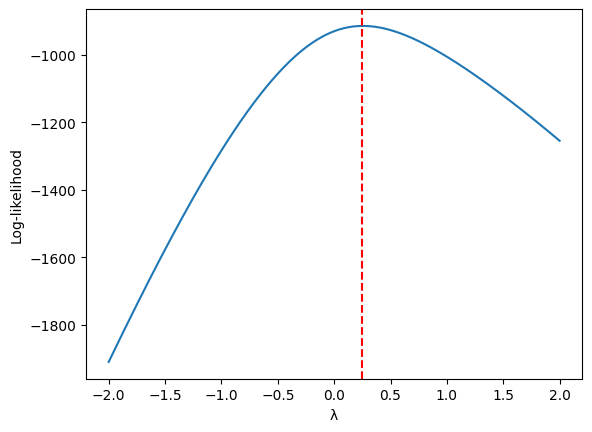

In [19]:
# Pre‐treatment subset
df_pre = df_ct[df_ct['year'] < 2017].copy()
y = df_pre['crime_rate_per_100k'].values
n = len(y)

# Set up grid of λ
lambdas = np.linspace(-2, 2, 401)
llf = []

# Loop: transform, regress on FEs, compute log‐likelihood
for lam in lambdas:
    # transform
    if abs(lam) < 1e-6:
        yt = np.log(y)
    else:
        yt = (y**lam - 1) / lam
        
    df_pre['yt'] = yt
    mod = smf.ols("yt ~ C(canton) + C(group)", data=df_pre).fit()
    rss = np.sum(mod.resid**2)

    ll = - (n/2) * np.log(rss / n) + (lam - 1) * np.sum(np.log(y))
    llf.append(ll)

# 4) Gather and find optimum
df_bc = pd.DataFrame({'lambda': lambdas, 'llf': llf})
best = df_bc.loc[df_bc['llf'].idxmax()]

print(f"Optimal λ≈ {best['lambda']:.3f}")
# Optionally: 95% CI where llf ≥ max(llf) - χ²(1,0.95)/2 ≈ drop of 1.92
crit = best['llf'] - 1.92
ci = df_bc.loc[df_bc['llf'] >= crit, 'lambda'].agg(['min','max'])
print(f"Approx 95% CI: [{ci['min']:.3f}, {ci['max']:.3f}]")

# 5) Show the full profile 
import matplotlib.pyplot as plt
plt.plot(df_bc['lambda'], df_bc['llf'])
plt.axvline(best['lambda'], color='red', linestyle='--')
plt.xlabel('λ')
plt.ylabel('Log‐likelihood')
plt.show()


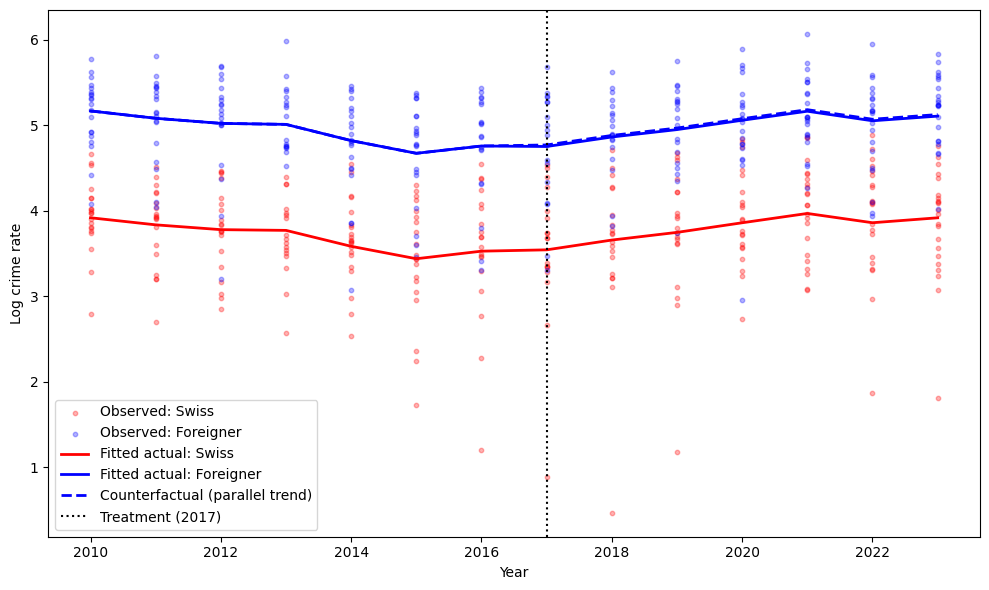

In [20]:
# Build a “counterfactual” dataset where Foreigner keeps its pre-treatment trend:
df_ct_cf = df_ct.copy()
# zero out the post dummy so the Foreigner×Post jump vanishes
df_ct_cf['T_P'] = 0

# Predict both actual and counterfactual paths
df_ct['f_actual'] = mod2.predict(df_ct)
df_ct_cf['f_cf']    = mod2.predict(df_ct_cf)

# Aggregate to year × group means
agg = (
    df_ct
    .assign(f_cf=df_ct_cf['f_cf'])
    .groupby(['group','year'])
    .agg(obs_rate=('log_crime_rate','mean'),
         fit_actual=('f_actual','mean'),
         fit_cf    =('f_cf','mean'))
    .reset_index())

plt.figure(figsize=(10,6))

for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = df_ct[df_ct['group'] == grp]
    plt.scatter(sub['year'], sub['log_crime_rate'],
                color=color, alpha=0.3, s=10,
                label=f'Observed: {grp}')

for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = agg[agg['group']==grp]
    plt.plot(sub['year'], sub['fit_actual'], color=color, lw=2,
             label=f'Fitted actual: {grp}')
    if grp=='Foreigner':
        plt.plot(sub['year'], sub['fit_cf'], color=color, lw=2, ls='--',
                 label='Counterfactual (parallel trend)')

plt.axvline(2017, color='black', ls=':', lw=1.5, label='Treatment (2017)')

plt.xlabel('Year')
plt.ylabel('Log crime rate')
plt.legend()
plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/did_graph_loglin.png", dpi=300, bbox_inches='tight')  
plt.show()